# 3 Data Preprocessing<a id='3_Data_Preprocessing'></a>

## 3.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
    * [2.2.1 Recap Of Data Science Problem](#2.2.1_Recap_Of_Data_Science_Problem)
    * [2.2.2 Objective of Data Wrangling](#2.2.2_Objective_of_Data_Wrangling)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Load The Data](#2.4_Load_The_Data)
  * [2.5 Explore The Data](#2.5_Explore_The_Data)
    * [2.5.1 Find Duplicates](#2.5.1_Find_Duplicates)
    * [2.5.2 Find Missing Values](#2.5.2_Find_Missing_Values)
    * [2.5.3 Find Dimensions for Time Series](#2.5.3_Find_Dimensions_for_Time_Series)
      * [2.5.3.1 Total Number of Time Series](#2.5.3.1_Total_Number_of_Time_Series)
      * [2.5.3.2 Time Span of Time Series](#2.5.3.2_Time_Span_of_Time_Series)
        * [2.5.3.2.1 Time Span of Time Series in Weekly_sales Dataframe](#2.5.3.2.1_Time_Span_of_Time_Series_in_Weekly_sales_Dataframe)
        * [2.5.3.2.2 Time Span of Time Series in Features Dataframe](#2.5.3.2.2_Time_Span_of_Time_Series_in_Features _Dataframe)
    * [2.5.4 Time Trend of Weekly Sales](#2.5.4_Time_Trend_of_Weekly_Sales)
      * [2.5.4.1 Time Trend of Weekly Sales for Dept](#2.5.4.1_Time_Trend_of_Weekly_Sales_for_Dept)
      * [2.5.4.2 Completeness of Weekly Sales Records](#2.5.4.2_Completeness_of_Weekly_Sales_Records)
    * [2.5.5 Categorical Features](#2.5.5_Categorical_Features)
      * [2.5.5.1 Store Type](#2.5.5.1_Store_Type)
        * [2.5.5.1.1 Store Size for Different Store Type](#2.5.5.1.1_Store_Size_for_Different_Store_Type)
        * [2.5.5.1.2 Weekly Sales for Different Store Type](#2.5.5.1.2_Weekly_Sales_for_Different_Store_Type)
      * [2.5.5.2 Holiday Effect](#2.5.5.2_Holiday_Effect)
    * [2.5.6 Numerical Features](#2.5.6_Numerical_Features)
      * [2.5.6.1 Numerical Variables in features df](#2.5.6.1_Numerical_Variables_in_Features_df)
        * [2.5.6.1.1 Numerical Variables Summary](#2.5.6.1.1_Numerical_Variables_Summary)
        * [2.5.6.1.2 Numerical Variables Distribution](#2.5.6.1.2_Numerical_Variables_Distribution)
      * [2.5.6.2 Numerical Variables in weekly_sales_type df](#2.5.6.2_Numerical_Variables_in_Weekly_Sales_Type_df)
  * [2.6 Merge The Data](#2.6_Merge_The_Data)
  * [2.7 Save The dData](#2.7_Save_The_data)
  * [2.8 Summary](#2.8_Summary)


## 3.2 Objectives<a id='3.2_Objectives'></a>

2. Image preprocessing 
    
    1) Image normalization due to various image intensity 
    
    2) noise reduction technique - guassian blurring
    
    3) image augmentation
    
    4) ROI selection?
    

3. feature extraction
    1) statistical features like intensity mean, standard deviation, skewness, and kurtosis from the pixel intensity distributions.
 
    2) Shape and Contour Features: Hough Transform for detecting shapes in the X-ray which might be indicative of particular conditions.
    
    3) texture/orientation features: Gabor Filters
    
    4) deep learning CNNs
  
4. sample imbalance
   1) number in different cases are largely different, data imbalance might be a concern
    

In [33]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


## 3.3 Imports<a id='3.3_Imports'></a>

In [1]:
#import libs  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation,Dense, Flatten,BatchNormalization, Conv2D,MaxPool2D,Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,f1_score
import itertools
import os
import shutil
import random
import glob


import seaborn as sns
import os

import cv2
from sklearn.model_selection import train_test_split



## 3.4 Test_Train_split<a id='3.4_Test_Train_split'></a>

In [2]:
categories = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']  # List of categories

'''
def select_files(folder,proportion):
    files=[f for f in os.listdir(folder) if f.lower().endswith('.png','.jpg','jpeg')]
    num_selected_files=int(len(files)*proportion)
    selected_files=np.random.cjoice()files,num_selected_files,replace=False)
    return selected_files
'''

# Set a random seed for reproducibility
seed = 42

# Define a split ratio
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2 

# Define the base directories for train and test sets
base_train_dir = 'train'
base_validation_dir = 'validation'
base_test_dir = 'test'

In [5]:
# Create train and test directories if they don't exist
if not os.path.exists(base_train_dir):
    os.makedirs(base_train_dir)
    
if not os.path.exists(base_validation_dir):
    os.makedirs(base_validation_dir)

if not os.path.exists(base_test_dir):
    os.makedirs(base_test_dir)

for category in categories:
    # Create category subdirectories in train and test directories
    train_category_dir = os.path.join(base_train_dir, category)
    validation_category_dir = os.path.join(base_validation_dir, category)
    test_category_dir = os.path.join(base_test_dir, category)

    if not os.path.exists(train_category_dir):
        os.makedirs(train_category_dir)
        
    if not os.path.exists(validation_category_dir):
        os.makedirs(validation_category_dir)
    
    if not os.path.exists(test_category_dir):
        os.makedirs(test_category_dir)

    # Get the list of images from the first subdirectory of the category
    subfolders = [d for d in os.listdir(category) if os.path.isdir(os.path.join(category, d))]  
    first_subfolder = os.path.join(category, subfolders[0])
    if os.path.isdir(first_subfolder):
        images = [img for img in os.listdir(first_subfolder) if img.endswith('.png')]

    # Train-test split for the current category
     # Select only 10% of images to use for this category
    _, use_images = train_test_split(images, test_size=0.15, random_state=seed)
    train_val_images, test_images = train_test_split(use_images, test_size=test_ratio, random_state=seed)
    train_images, val_images = train_test_split(train_val_images, test_size=validation_ratio/(train_ratio+validation_ratio), random_state=seed)

    # Move images to their respective train/test category directories
    for img in train_images:
        source = os.path.join(category, subfolders[0], img)
        destination = os.path.join(train_category_dir, img)
        shutil.copy(source, destination)
        
    for img in val_images:
        source = os.path.join(category, subfolders[0], img)
        destination = os.path.join(validation_category_dir, img)
        shutil.copy(source, destination)

    for img in test_images:
        source = os.path.join(category, subfolders[0], img)
        destination = os.path.join(test_category_dir, img)
        shutil.copy(source, destination)

## 3.5 Baseline Model

### 3.5.1 Image preprocessing

In [36]:
#generate batches of data which can be put in sequential model 

#you can add augmentation or rescaling parameters here
#Frist, start without setting any parameters, since basic model already add rescaling function
Image_generator=ImageDataGenerator(rescale=1./255)

#creat batches of data from directory where train,val,test dataset are, target_size are set as 224 since pre-trained model VGG16 is using image with size of 224
train_batches=Image_generator.flow_from_directory(directory=base_train_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
val_batches=Image_generator.flow_from_directory(directory=base_validation_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
#only set shuffle to be false for test dataset since we need to use test dataset as reference for confusion matrix where
test_batches=Image_generator.flow_from_directory(directory=base_test_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32,shuffle=False)


Found 2219 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 637 images belonging to 4 classes.


In [37]:
#each batch contains 10 images and corresponding labels
imgs,labels=next(train_batches)

def adjustImages(image):
    min_val=np.min(img)
    max_val=np.max(img)
    adjusted_img=(img-min_val)/(max_val-min_val)
    return adjusted_img

In [38]:
num_images=imgs.shape[0]

In [39]:
num_images

32

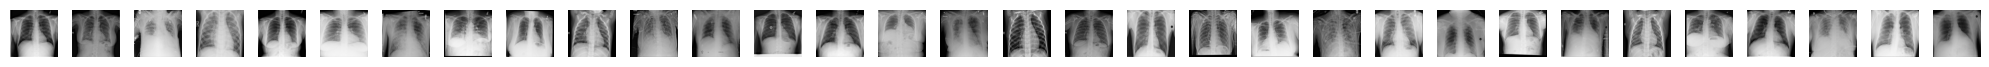

In [40]:
fig,axes=plt.subplots(1,num_images,figsize=(20,10))

    
for i,ax in enumerate(axes):
        
    ax.imshow(imgs[i])
    ax.axis('off')
    plt.tight_layout()
#    ax.set_title(f"label:{np.argmax(label[i])}")
plt.tight_layout()
plt.show()

### 3.5.2 Basic CNN model

In [41]:
#build baseline model with minimal preprocessing by applying only normalization to the images
##input_shape=() must be in the first layer of the model, if the first layer is rescale=1./255, then add input_shape in this layer instead of conv2D
basic_CNN_model=Sequential([
                      Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(299,299,3)),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Conv2D(filters=32, kernel_size=(3,3),activation='relu'),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Flatten(),
                      Dense(units=4,activation='softmax')
                    ])
        #rescaling layer  to normaliza the input images, use 1./255 not becasue of image dimension, but because it's related to pixel intensity range, 
        #pixel intensity is represented by 8-bit value, range from 0-255, not the height by width of the image
        #padding is used to maintain the edge information, keep size of feature map same as input images
        #each filter is to detect specific type of feature, each filter will produce feature map
                      

In [42]:
basic_CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 299, 299, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 170528)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                

In [43]:
basic_CNN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy', Recall(name='basic_recall')])

In [44]:
basic_CNN_model.fit(x=train_batches,validation_data=val_batches,epochs=10,verbose=1)

Epoch 1/10
70/70 [==============================] - 36s 504ms/step - loss: 1.0474 - accuracy: 0.5561 - basic_recall: 0.3398 - val_loss: 1.0844 - val_accuracy: 0.4500 - val_basic_recall: 0.3094
Epoch 2/10
70/70 [==============================] - 33s 469ms/step - loss: 0.8735 - accuracy: 0.6399 - basic_recall: 0.5029 - val_loss: 0.8497 - val_accuracy: 0.6500 - val_basic_recall: 0.4688
Epoch 3/10
70/70 [==============================] - 32s 457ms/step - loss: 0.7802 - accuracy: 0.6791 - basic_recall: 0.5638 - val_loss: 0.7311 - val_accuracy: 0.7125 - val_basic_recall: 0.5813
Epoch 4/10
70/70 [==============================] - 31s 448ms/step - loss: 0.6709 - accuracy: 0.7368 - basic_recall: 0.6345 - val_loss: 0.6701 - val_accuracy: 0.7188 - val_basic_recall: 0.6594
Epoch 5/10
70/70 [==============================] - 32s 450ms/step - loss: 0.6085 - accuracy: 0.7526 - basic_recall: 0.6778 - val_loss: 0.6507 - val_accuracy: 0.7344 - val_basic_recall: 0.6375
Epoch 6/10
70/70 [=================

### 3.5.3 Predict the Image 

In [45]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [46]:
test_imgs,test_labels=next(test_batches)

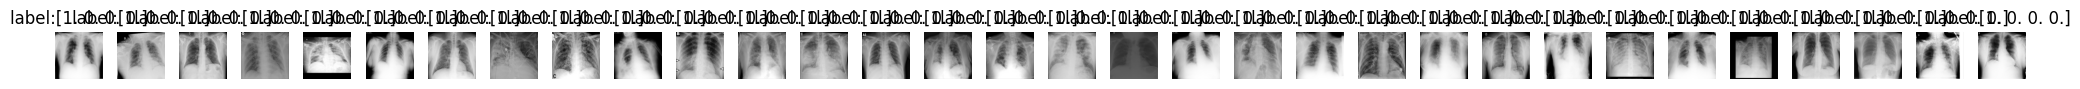

In [47]:
fig,axes=plt.subplots(1,num_images,figsize=(20,5))

    
for i,ax in enumerate(axes):
        
    ax.imshow(test_imgs[i])
    ax.axis('off')
    plt.tight_layout()
    ax.set_title(f"label:{test_labels[i]}")
plt.tight_layout()
plt.show()

In [48]:
predictions=basic_CNN_model.predict(x=test_batches,verbose=0)

In [49]:
np.round(predictions)[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [50]:
test_batches.class_indices

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2, 'Lung_Opacity': 3}

In [25]:
class_names=['COVID','Normal','Viral Pneumonia','Lung_Opacity']

In [23]:
def classification_table(y_true,y_pred,class_names):
    classification_report_dict=classification_report(y_true,y_pred,output_dict=True,target_names=class_names)
    report_df=pd.DataFrame(classification_report_dict)
    return report_df.T
    

In [53]:
y_true=test_batches.classes
y_pred=np.argmax(predictions,axis=1)

In [54]:
classification_table(y_true,y_pred,class_names)

,precision,recall,f1-score,support
COVID,0.823529,0.385321,0.525000,109.000000
Normal,0.788520,0.852941,0.819466,306.000000
Viral Pneumonia,0.897436,0.853659,0.875000,41.000000
Lung_Opacity,0.648148,0.773481,0.705290,181.000000
accuracy,0.750392,0.750392,0.750392,0.750392
macro avg,0.789408,0.716350,0.731189,637.000000
weighted avg,0.761635,0.750392,0.740211,637.000000


In [55]:
base_confusion_matrix=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=1))

In [27]:
def CM_plot(confusion_matrix, color):
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix,annot=True,cmap=color,xticklabels=class_names,yticklabels=class_names)
    plt.title('Confusion Matrix')
   
    #tick_marks=np.arrange(len(classes))
    plt.xlabel=('True Label')
    plt.ylabel=('Predicted Label')
    plt.show()
    
   

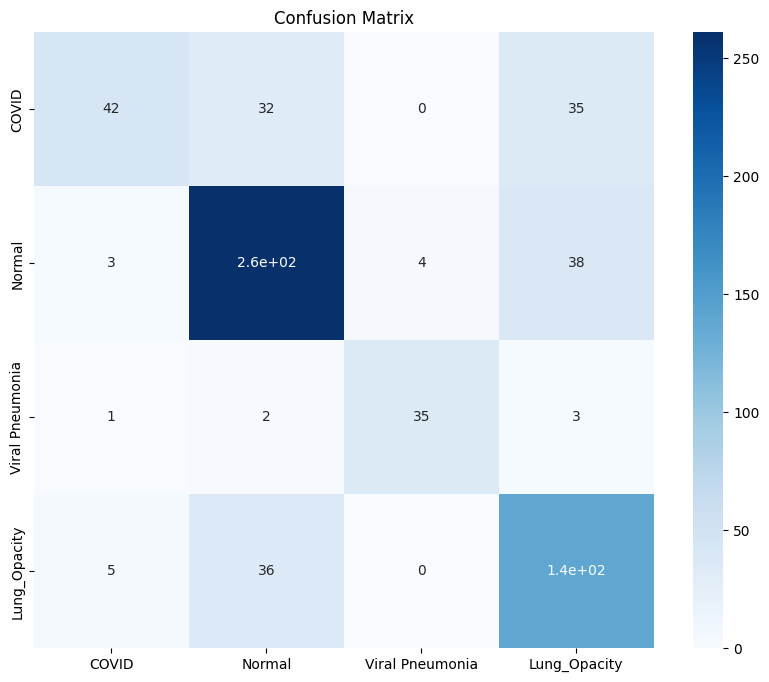

In [57]:
CM_plot(base_confusion_matrix, "Blues")

In [58]:
confusion_matrix_normalized=base_confusion_matrix.astype('float')/base_confusion_matrix.sum(axis=1)[:,np.newaxis]

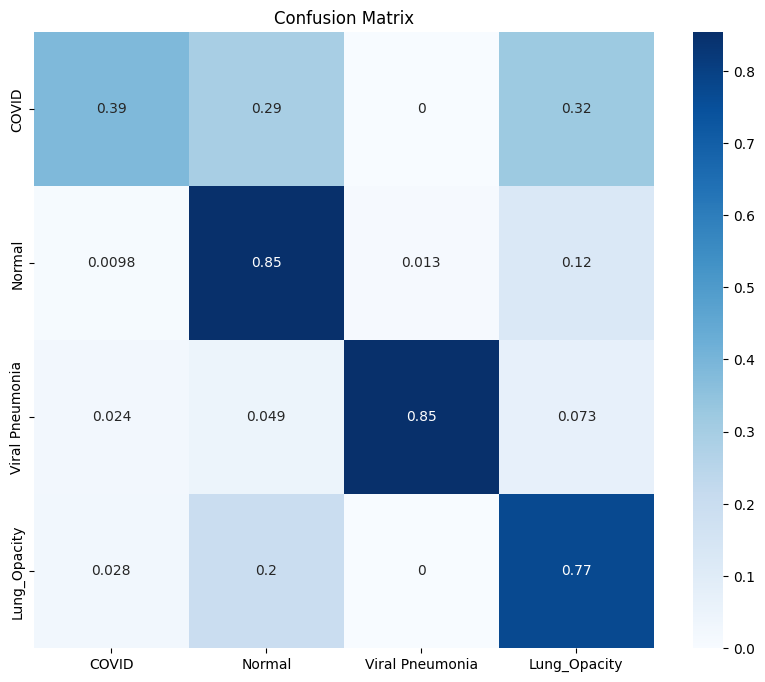

In [59]:
CM_plot(confusion_matrix_normalized, "Blues")

# 3.6 CNN model with Image Augmentation

### 3.6.1 Image Augmentation

In [3]:
#generate batches of data which can be put in sequential model 

#you can add augmentation or rescaling parameters here
#Frist, only apply augmentation to the training dataset

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8048393/
    
Train_Image_generator_minor=ImageDataGenerator(rescale=1./255,rotation_range=15,zoom_range=0.1,horizontal_flip=True, width_shift_range=0.1,brightness_range=[0.9,1.1],fill_mode='nearest')
Train_Image_generator_major=ImageDataGenerator(rescale=1./255,rotation_range=10,zoom_range=0.1,fill_mode='nearest')
#not apply to test dataset, only rescale the validation/test dataset
Image_generator_rescale=ImageDataGenerator(rescale=1./255)

In [10]:
#creat batches of data from directory where train,val,test dataset are, target_size are set as 224 since pre-trained model VGG16 is using image with size of 224
train_COVID=Train_Image_generator_minor.flow_from_directory(directory=base_train_dir+'/'+'COVID',target_size=(299,299), classes='COVID',batch_size=32)
train_viral=Train_Image_generator_minor.flow_from_directory(directory=base_train_dir+'/'+'Viral Pneumonia',target_size=(299,299), class_mode='categorical',batch_size=32)
train_normal=Train_Image_generator_major.flow_from_directory(directory=base_train_dir+'/'+'Normal',target_size=(299,299), class_mode='categorical',batch_size=32)
train_opacity=Train_Image_generator_major.flow_from_directory(directory=base_train_dir+'/'+'Lung_Opacity',target_size=(299,299), class_mode='categorical',batch_size=32)

val_batches=Image_generator_rescale.flow_from_directory(directory=base_validation_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
#only set shuffle to be false for test dataset since we need to use test dataset as reference for confusion matrix where

test_batches=Image_generator_rescale.flow_from_directory(directory=base_test_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32,shuffle=False)

Found 0 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 1969 images belonging to 4 classes.
Found 3715 images belonging to 4 classes.


In [9]:
base_train_dir+'/'+'COVID'

'train/COVID'

In [61]:
Aug_CNN_model=Sequential([Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(299,299,3)),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Conv2D(filters=32, kernel_size=(3,3),activation='relu',padding='same'),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Flatten(),
                      Dense(units=4,activation='softmax')])

In [62]:
def fit_model(model,l_r,train,val,ep,vb):
    model.compile(optimizer=Adam(learning_rate=l_r), loss='categorical_crossentropy',metrics=['accuracy',Recall(name='Aug_init_recall')])
    history=model.fit(x=train,validation_data=val,epochs=ep,verbose=vb)
    return model, history

In [63]:
def pred(model,x_test,vb):
    predictions=model.predict(x=x_test,verbose=vb)
    return predictions
    

In [64]:
Aug_CNN_model,history=fit_model(Aug_CNN_model,0.0001,train_batches,val_batches,10,1)

Epoch 1/10
70/70 [==============================] - 62s 878ms/step - loss: 1.1647 - accuracy: 0.4912 - Aug_init_recall: 0.2835 - val_loss: 0.9609 - val_accuracy: 0.6250 - val_Aug_init_recall: 0.4344
Epoch 2/10
70/70 [==============================] - 62s 878ms/step - loss: 0.9533 - accuracy: 0.6048 - Aug_init_recall: 0.4191 - val_loss: 0.8605 - val_accuracy: 0.6594 - val_Aug_init_recall: 0.5469
Epoch 3/10
70/70 [==============================] - 62s 879ms/step - loss: 0.9064 - accuracy: 0.6210 - Aug_init_recall: 0.4745 - val_loss: 0.8733 - val_accuracy: 0.6375 - val_Aug_init_recall: 0.5688
Epoch 4/10
70/70 [==============================] - 62s 881ms/step - loss: 0.8841 - accuracy: 0.6318 - Aug_init_recall: 0.4831 - val_loss: 0.8107 - val_accuracy: 0.6750 - val_Aug_init_recall: 0.6094
Epoch 5/10
70/70 [==============================] - 62s 884ms/step - loss: 0.8519 - accuracy: 0.6489 - Aug_init_recall: 0.5201 - val_loss: 0.8651 - val_accuracy: 0.6438 - val_Aug_init_recall: 0.6187
Epoch

In [65]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'Aug_init_recall', 'val_loss', 'val_accuracy', 'val_Aug_init_recall'])

In [66]:
Aug_predictions= Aug_CNN_model.predict(x=test_batches,verbose=0)
np.round(Aug_predictions)[:10]

array([[0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [67]:
y_true=test_batches.classes
Aug_y_pred=np.argmax(Aug_predictions,axis=1)
classification_table(y_true,Aug_y_pred,class_names)

,precision,recall,f1-score,support
COVID,0.720000,0.165138,0.268657,109.000000
Normal,0.716216,0.866013,0.784024,306.000000
Viral Pneumonia,0.756098,0.756098,0.756098,41.000000
Lung_Opacity,0.661692,0.734807,0.696335,181.000000
accuracy,0.701727,0.701727,0.701727,0.701727
macro avg,0.713501,0.630514,0.626278,637.000000
weighted avg,0.703938,0.701727,0.669123,637.000000


In [68]:
Aug_confusion_matrix=confusion_matrix(y_true=y_true,y_pred=Aug_y_pred)

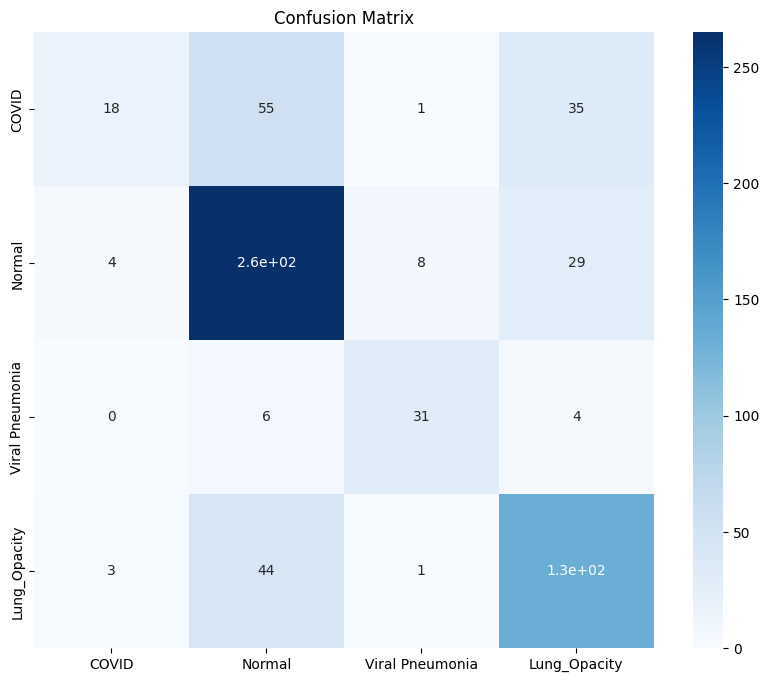

In [69]:
CM_plot(Aug_confusion_matrix, "Blues")

In [70]:
Aug_confusion_matrix_normalized=Aug_confusion_matrix.astype('float')/Aug_confusion_matrix.sum(axis=1)[:,np.newaxis]

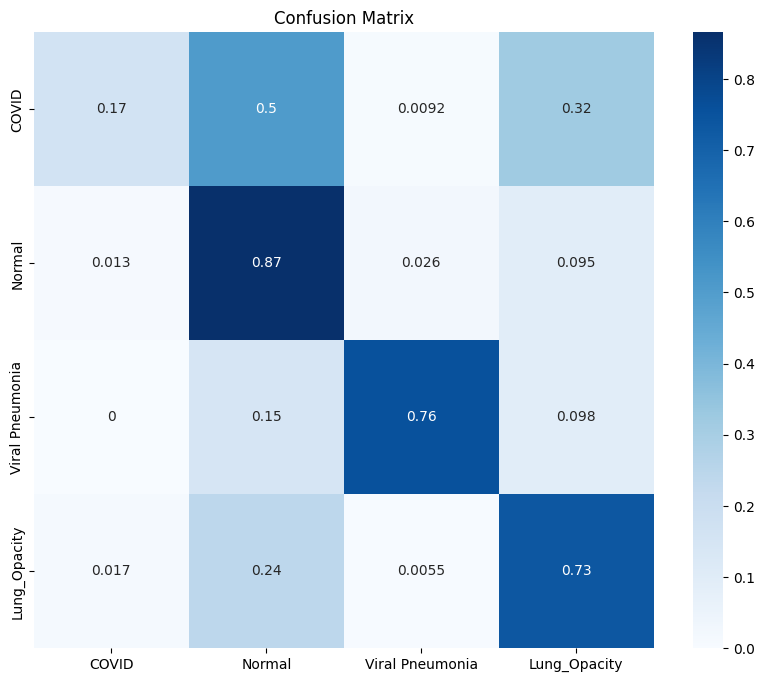

In [71]:
CM_plot(Aug_confusion_matrix_normalized, "Blues")

### 3.6.2 hyperparameter tuning for augmentation

In [72]:
#1. define grid of parameters
rotation_values=[0,5,10,20]
zoom_values=[0,0.1,0,2]
width_shift_values=[0,0.1]
horizontal_flip=[True,False]

augmentation_configs = []
for width_shift in width_shift_values:
    for rotation in rotation_values:
        for zoom_range in zoom_values:
            for flip in horizontal_flip:
                config_name = f"ws_{width_shift}_rot_{rotation}_zoom_{zoom_range}_filp_{flip}"
                augmentation_configs.append({
                    'name': config_name,
                    'rotation_range': rotation,
                    'width_shift_range': width_shift,
                    'zoom_range':zoom_range,
                    'horizontal_flip':flip
               })

In [76]:
def grid_search_augmentation(config,model,train_dir,val_dir,ep):
    train_data_generator=ImageDataGenerator(rescale=1./255,rotation_range=config['rotation_range'],width_shift_range=config['width_shift_range'],
                                           zoom_range=config['zoom_range'],horizontal_flip=config['horizontal_flip'],fill_mode='nearest')
    val_data_generator=ImageDataGenerator(rescale=1./255)
    
    train_batches=train_data_generator.flow_from_directory(directory=train_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
    val_batches=val_data_generator.flow_from_directory(directory=val_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
    model=model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy',Recall(name='grid_search_recall')])
    history=model.fit(train_batches,epochs=ep,validation_data=val_batches,verbose=2)
    best_val_recall=max(history.history['val_grid_search_recall'])
    print(f"Config:{config['name']},best_val_recall:{best_val_recall}")
    return best_val_recall


In [79]:
def grid_search_augmentation_V2(config,model_dir,model,train_dir,val_dir,ep):
    train_data_generator=ImageDataGenerator(rescale=1./255,rotation_range=config['rotation_range'],width_shift_range=config['width_shift_range'],
                                           zoom_range=config['zoom_range'],horizontal_flip=config['horizontal_flip'],fill_mode='nearest')
    val_data_generator=ImageDataGenerator(rescale=1./255)
    
    train_batches=train_data_generator.flow_from_directory(directory=train_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
    val_batches=val_data_generator.flow_from_directory(directory=val_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
    #clone the model for each configuration
    model=tf.keras.models.clone_model(model)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy',Recall(name='grid_search_V2_recall')])
    
    #create unique name for the model
    model_name='model_{}.h5'.format(config['name'])
    
    #create directory named "saved models"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    #define model checkpoint
    checkpoint_path=os.path.join(model_dir,model_name)
    checkpoint_callback=ModelCheckpoint(checkpoint_path,save_best_only=True,monitor='val_grid_search_V2_recall',mode='max')
    
    history=model.fit(train_batches,epochs=ep,validation_data=val_batches,verbose=2,callbacks=[checkpoint_callback])
    best_val_recall=max(history.history['val_grid_search_V2_recall'])
    print(f"Config:{config['name']},best_val_recall:{best_val_recall}")
    return best_val_recall,checkpoint_path


In [74]:
Aug_CNN_model_grid=Sequential([Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(299,299,3)),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Conv2D(filters=32, kernel_size=(3,3),activation='relu',padding='same'),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Flatten(),
                      Dense(units=4,activation='softmax')])

In [80]:
results=[]
for config in augmentation_configs:
    recall,checkpoint_path=grid_search_augmentation_V2(config,"saved_models",Aug_CNN_model_grid,'train','validation',10)
    results.append({'configure':config['name'],'Recall':recall,'checkpoint_path':checkpoint_path})

Found 2219 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Epoch 1/10
70/70 - 33s - loss: 1.0668 - accuracy: 0.5309 - grid_search_V2_recall: 0.3137 - val_loss: 0.9357 - val_accuracy: 0.5562 - val_grid_search_V2_recall: 0.4406 - 33s/epoch - 473ms/step
Epoch 2/10


C:\Users\ygao10\Anaconda3\envs\imageML\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 - 32s - loss: 0.8706 - accuracy: 0.6345 - grid_search_V2_recall: 0.4957 - val_loss: 0.8125 - val_accuracy: 0.6625 - val_grid_search_V2_recall: 0.5031 - 32s/epoch - 457ms/step
Epoch 3/10
70/70 - 32s - loss: 0.7934 - accuracy: 0.6706 - grid_search_V2_recall: 0.5579 - val_loss: 0.8681 - val_accuracy: 0.6625 - val_grid_search_V2_recall: 0.6187 - 32s/epoch - 464ms/step
Epoch 4/10
70/70 - 32s - loss: 0.7444 - accuracy: 0.6940 - grid_search_V2_recall: 0.5989 - val_loss: 0.6879 - val_accuracy: 0.7312 - val_grid_search_V2_recall: 0.6344 - 32s/epoch - 459ms/step
Epoch 5/10
70/70 - 32s - loss: 0.6702 - accuracy: 0.7359 - grid_search_V2_recall: 0.6426 - val_loss: 0.6682 - val_accuracy: 0.7156 - val_grid_search_V2_recall: 0.6500 - 32s/epoch - 460ms/step
Epoch 6/10
70/70 - 32s - loss: 0.6425 - accuracy: 0.7409 - grid_search_V2_recall: 0.6462 - val_loss: 0.6580 - val_accuracy: 0.7531 - val_grid_search_V2_recall: 0.6500 - 32s/epoch - 460ms/step
Epoch 7/10
70/70 - 32s - loss: 0.5971 - accuracy: 0

Epoch 2/10
70/70 - 31s - loss: 0.8664 - accuracy: 0.6390 - grid_search_V2_recall: 0.4975 - val_loss: 0.8409 - val_accuracy: 0.6500 - val_grid_search_V2_recall: 0.4938 - 31s/epoch - 447ms/step
Epoch 3/10
70/70 - 32s - loss: 0.8023 - accuracy: 0.6683 - grid_search_V2_recall: 0.5448 - val_loss: 0.8027 - val_accuracy: 0.6719 - val_grid_search_V2_recall: 0.5281 - 32s/epoch - 450ms/step
Epoch 4/10
70/70 - 31s - loss: 0.7485 - accuracy: 0.6918 - grid_search_V2_recall: 0.5868 - val_loss: 0.7166 - val_accuracy: 0.7250 - val_grid_search_V2_recall: 0.6250 - 31s/epoch - 450ms/step
Epoch 5/10
70/70 - 32s - loss: 0.7186 - accuracy: 0.7071 - grid_search_V2_recall: 0.6102 - val_loss: 0.6918 - val_accuracy: 0.7219 - val_grid_search_V2_recall: 0.6313 - 32s/epoch - 451ms/step
Epoch 6/10
70/70 - 32s - loss: 0.6643 - accuracy: 0.7283 - grid_search_V2_recall: 0.6417 - val_loss: 0.6483 - val_accuracy: 0.7406 - val_grid_search_V2_recall: 0.6687 - 32s/epoch - 451ms/step
Epoch 7/10
70/70 - 32s - loss: 0.6160 - 

Epoch 2/10
70/70 - 55s - loss: 0.8860 - accuracy: 0.6350 - grid_search_V2_recall: 0.4831 - val_loss: 0.8547 - val_accuracy: 0.6625 - val_grid_search_V2_recall: 0.6094 - 55s/epoch - 791ms/step
Epoch 3/10
70/70 - 56s - loss: 0.8276 - accuracy: 0.6539 - grid_search_V2_recall: 0.5381 - val_loss: 0.7727 - val_accuracy: 0.6750 - val_grid_search_V2_recall: 0.5969 - 56s/epoch - 804ms/step
Epoch 4/10
70/70 - 59s - loss: 0.7805 - accuracy: 0.6742 - grid_search_V2_recall: 0.5750 - val_loss: 0.7150 - val_accuracy: 0.7094 - val_grid_search_V2_recall: 0.6125 - 59s/epoch - 837ms/step
Epoch 5/10
70/70 - 56s - loss: 0.7557 - accuracy: 0.6845 - grid_search_V2_recall: 0.5904 - val_loss: 0.7189 - val_accuracy: 0.7094 - val_grid_search_V2_recall: 0.6531 - 56s/epoch - 806ms/step
Epoch 6/10
70/70 - 55s - loss: 0.7137 - accuracy: 0.7021 - grid_search_V2_recall: 0.6205 - val_loss: 0.7113 - val_accuracy: 0.7000 - val_grid_search_V2_recall: 0.6656 - 55s/epoch - 790ms/step
Epoch 7/10
70/70 - 56s - loss: 0.6916 - 

Epoch 2/10
70/70 - 55s - loss: 0.9335 - accuracy: 0.5949 - grid_search_V2_recall: 0.4470 - val_loss: 0.8091 - val_accuracy: 0.6687 - val_grid_search_V2_recall: 0.5344 - 55s/epoch - 783ms/step
Epoch 3/10
70/70 - 56s - loss: 0.8231 - accuracy: 0.6512 - grid_search_V2_recall: 0.5340 - val_loss: 0.7728 - val_accuracy: 0.6750 - val_grid_search_V2_recall: 0.6156 - 56s/epoch - 805ms/step
Epoch 4/10
70/70 - 56s - loss: 0.7724 - accuracy: 0.6706 - grid_search_V2_recall: 0.5638 - val_loss: 0.7352 - val_accuracy: 0.7219 - val_grid_search_V2_recall: 0.6438 - 56s/epoch - 796ms/step
Epoch 5/10
70/70 - 55s - loss: 0.7557 - accuracy: 0.6890 - grid_search_V2_recall: 0.5849 - val_loss: 0.7349 - val_accuracy: 0.6781 - val_grid_search_V2_recall: 0.6094 - 55s/epoch - 790ms/step
Epoch 6/10
70/70 - 56s - loss: 0.7236 - accuracy: 0.7017 - grid_search_V2_recall: 0.6124 - val_loss: 0.6804 - val_accuracy: 0.7219 - val_grid_search_V2_recall: 0.6344 - 56s/epoch - 796ms/step
Epoch 7/10
70/70 - 54s - loss: 0.6927 - 

Epoch 2/10
70/70 - 56s - loss: 0.9139 - accuracy: 0.6138 - grid_search_V2_recall: 0.4624 - val_loss: 0.8452 - val_accuracy: 0.6469 - val_grid_search_V2_recall: 0.5813 - 56s/epoch - 807ms/step
Epoch 3/10
70/70 - 56s - loss: 0.8559 - accuracy: 0.6413 - grid_search_V2_recall: 0.5241 - val_loss: 0.8240 - val_accuracy: 0.6812 - val_grid_search_V2_recall: 0.6281 - 56s/epoch - 802ms/step
Epoch 4/10
70/70 - 56s - loss: 0.8147 - accuracy: 0.6557 - grid_search_V2_recall: 0.5453 - val_loss: 0.7643 - val_accuracy: 0.6906 - val_grid_search_V2_recall: 0.5437 - 56s/epoch - 798ms/step
Epoch 5/10
70/70 - 56s - loss: 0.7940 - accuracy: 0.6679 - grid_search_V2_recall: 0.5660 - val_loss: 0.7633 - val_accuracy: 0.6812 - val_grid_search_V2_recall: 0.6156 - 56s/epoch - 793ms/step
Epoch 6/10
70/70 - 56s - loss: 0.7641 - accuracy: 0.6764 - grid_search_V2_recall: 0.5854 - val_loss: 0.7407 - val_accuracy: 0.6812 - val_grid_search_V2_recall: 0.6000 - 56s/epoch - 796ms/step
Epoch 7/10
70/70 - 55s - loss: 0.7492 - 

Epoch 2/10
70/70 - 56s - loss: 0.9267 - accuracy: 0.6147 - grid_search_V2_recall: 0.4362 - val_loss: 0.8679 - val_accuracy: 0.6344 - val_grid_search_V2_recall: 0.5625 - 56s/epoch - 806ms/step
Epoch 3/10
70/70 - 58s - loss: 0.8425 - accuracy: 0.6485 - grid_search_V2_recall: 0.5169 - val_loss: 0.7672 - val_accuracy: 0.6906 - val_grid_search_V2_recall: 0.5656 - 58s/epoch - 822ms/step
Epoch 4/10
70/70 - 60s - loss: 0.7909 - accuracy: 0.6719 - grid_search_V2_recall: 0.5557 - val_loss: 0.7277 - val_accuracy: 0.7000 - val_grid_search_V2_recall: 0.6062 - 60s/epoch - 861ms/step
Epoch 5/10
70/70 - 59s - loss: 0.7606 - accuracy: 0.6890 - grid_search_V2_recall: 0.5922 - val_loss: 0.7060 - val_accuracy: 0.7000 - val_grid_search_V2_recall: 0.6469 - 59s/epoch - 837ms/step
Epoch 6/10
70/70 - 57s - loss: 0.7399 - accuracy: 0.6936 - grid_search_V2_recall: 0.6039 - val_loss: 0.6998 - val_accuracy: 0.7000 - val_grid_search_V2_recall: 0.6562 - 57s/epoch - 810ms/step
Epoch 7/10
70/70 - 56s - loss: 0.7071 - 

Epoch 2/10
70/70 - 57s - loss: 0.9409 - accuracy: 0.6066 - grid_search_V2_recall: 0.4412 - val_loss: 0.8682 - val_accuracy: 0.6469 - val_grid_search_V2_recall: 0.5063 - 57s/epoch - 815ms/step
Epoch 3/10
70/70 - 56s - loss: 0.8692 - accuracy: 0.6377 - grid_search_V2_recall: 0.5183 - val_loss: 0.8417 - val_accuracy: 0.6531 - val_grid_search_V2_recall: 0.5938 - 56s/epoch - 799ms/step
Epoch 4/10
70/70 - 56s - loss: 0.8426 - accuracy: 0.6435 - grid_search_V2_recall: 0.5286 - val_loss: 0.7758 - val_accuracy: 0.6938 - val_grid_search_V2_recall: 0.5781 - 56s/epoch - 805ms/step
Epoch 5/10
70/70 - 55s - loss: 0.8039 - accuracy: 0.6647 - grid_search_V2_recall: 0.5557 - val_loss: 0.7485 - val_accuracy: 0.6969 - val_grid_search_V2_recall: 0.5875 - 55s/epoch - 788ms/step
Epoch 6/10
70/70 - 56s - loss: 0.7863 - accuracy: 0.6751 - grid_search_V2_recall: 0.5696 - val_loss: 0.7649 - val_accuracy: 0.6781 - val_grid_search_V2_recall: 0.5562 - 56s/epoch - 806ms/step
Epoch 7/10
70/70 - 55s - loss: 0.7894 - 

Epoch 2/10
70/70 - 58s - loss: 0.9502 - accuracy: 0.5913 - grid_search_V2_recall: 0.4601 - val_loss: 0.8819 - val_accuracy: 0.6531 - val_grid_search_V2_recall: 0.5688 - 58s/epoch - 824ms/step
Epoch 3/10
70/70 - 56s - loss: 0.8604 - accuracy: 0.6489 - grid_search_V2_recall: 0.5083 - val_loss: 0.7894 - val_accuracy: 0.6906 - val_grid_search_V2_recall: 0.5906 - 56s/epoch - 806ms/step
Epoch 4/10
70/70 - 59s - loss: 0.8578 - accuracy: 0.6345 - grid_search_V2_recall: 0.5232 - val_loss: 0.7955 - val_accuracy: 0.6844 - val_grid_search_V2_recall: 0.6344 - 59s/epoch - 839ms/step
Epoch 5/10
70/70 - 58s - loss: 0.8287 - accuracy: 0.6516 - grid_search_V2_recall: 0.5399 - val_loss: 0.7580 - val_accuracy: 0.6781 - val_grid_search_V2_recall: 0.6031 - 58s/epoch - 832ms/step
Epoch 6/10
70/70 - 57s - loss: 0.7995 - accuracy: 0.6733 - grid_search_V2_recall: 0.5543 - val_loss: 0.7898 - val_accuracy: 0.6594 - val_grid_search_V2_recall: 0.6031 - 57s/epoch - 812ms/step
Epoch 7/10
70/70 - 56s - loss: 0.7869 - 

Epoch 2/10
70/70 - 59s - loss: 0.8970 - accuracy: 0.6269 - grid_search_V2_recall: 0.4781 - val_loss: 0.8295 - val_accuracy: 0.6531 - val_grid_search_V2_recall: 0.5531 - 59s/epoch - 839ms/step
Epoch 3/10
70/70 - 57s - loss: 0.8562 - accuracy: 0.6440 - grid_search_V2_recall: 0.5219 - val_loss: 0.8170 - val_accuracy: 0.6719 - val_grid_search_V2_recall: 0.5938 - 57s/epoch - 817ms/step
Epoch 4/10
70/70 - 58s - loss: 0.8213 - accuracy: 0.6480 - grid_search_V2_recall: 0.5439 - val_loss: 0.7633 - val_accuracy: 0.6875 - val_grid_search_V2_recall: 0.6094 - 58s/epoch - 832ms/step
Epoch 5/10
70/70 - 57s - loss: 0.8143 - accuracy: 0.6575 - grid_search_V2_recall: 0.5462 - val_loss: 0.7674 - val_accuracy: 0.6781 - val_grid_search_V2_recall: 0.6375 - 57s/epoch - 810ms/step
Epoch 6/10
70/70 - 57s - loss: 0.7643 - accuracy: 0.6854 - grid_search_V2_recall: 0.5714 - val_loss: 0.6916 - val_accuracy: 0.7250 - val_grid_search_V2_recall: 0.6156 - 57s/epoch - 812ms/step
Epoch 7/10
70/70 - 56s - loss: 0.7473 - 

Epoch 2/10
70/70 - 58s - loss: 0.9015 - accuracy: 0.6187 - grid_search_V2_recall: 0.4822 - val_loss: 0.8484 - val_accuracy: 0.6313 - val_grid_search_V2_recall: 0.5562 - 58s/epoch - 836ms/step
Epoch 3/10
70/70 - 60s - loss: 0.8565 - accuracy: 0.6453 - grid_search_V2_recall: 0.5110 - val_loss: 0.7743 - val_accuracy: 0.6781 - val_grid_search_V2_recall: 0.5375 - 60s/epoch - 851ms/step
Epoch 4/10
70/70 - 56s - loss: 0.8201 - accuracy: 0.6489 - grid_search_V2_recall: 0.5345 - val_loss: 0.7514 - val_accuracy: 0.6906 - val_grid_search_V2_recall: 0.6125 - 56s/epoch - 806ms/step
Epoch 5/10
70/70 - 60s - loss: 0.7867 - accuracy: 0.6787 - grid_search_V2_recall: 0.5647 - val_loss: 0.7661 - val_accuracy: 0.6500 - val_grid_search_V2_recall: 0.5781 - 60s/epoch - 862ms/step
Epoch 6/10
70/70 - 57s - loss: 0.7890 - accuracy: 0.6746 - grid_search_V2_recall: 0.5493 - val_loss: 0.7328 - val_accuracy: 0.6938 - val_grid_search_V2_recall: 0.5781 - 57s/epoch - 811ms/step
Epoch 7/10
70/70 - 59s - loss: 0.7359 - 

Epoch 2/10
70/70 - 59s - loss: 0.9151 - accuracy: 0.6242 - grid_search_V2_recall: 0.4745 - val_loss: 0.8266 - val_accuracy: 0.6500 - val_grid_search_V2_recall: 0.5063 - 59s/epoch - 848ms/step
Epoch 3/10
70/70 - 61s - loss: 0.8757 - accuracy: 0.6354 - grid_search_V2_recall: 0.4917 - val_loss: 0.7712 - val_accuracy: 0.6969 - val_grid_search_V2_recall: 0.5844 - 61s/epoch - 868ms/step
Epoch 4/10
70/70 - 58s - loss: 0.8157 - accuracy: 0.6602 - grid_search_V2_recall: 0.5340 - val_loss: 0.7402 - val_accuracy: 0.7000 - val_grid_search_V2_recall: 0.6187 - 58s/epoch - 833ms/step
Epoch 5/10
70/70 - 60s - loss: 0.8228 - accuracy: 0.6571 - grid_search_V2_recall: 0.5498 - val_loss: 0.7364 - val_accuracy: 0.6969 - val_grid_search_V2_recall: 0.6125 - 60s/epoch - 862ms/step
Epoch 6/10
70/70 - 58s - loss: 0.7991 - accuracy: 0.6598 - grid_search_V2_recall: 0.5588 - val_loss: 0.7360 - val_accuracy: 0.6844 - val_grid_search_V2_recall: 0.6313 - 58s/epoch - 823ms/step
Epoch 7/10
70/70 - 62s - loss: 0.7648 - 

Epoch 2/10
70/70 - 59s - loss: 0.9358 - accuracy: 0.6061 - grid_search_V2_recall: 0.4651 - val_loss: 0.8670 - val_accuracy: 0.6094 - val_grid_search_V2_recall: 0.5500 - 59s/epoch - 850ms/step
Epoch 3/10
70/70 - 60s - loss: 0.8899 - accuracy: 0.6332 - grid_search_V2_recall: 0.5088 - val_loss: 0.8129 - val_accuracy: 0.6687 - val_grid_search_V2_recall: 0.5625 - 60s/epoch - 858ms/step
Epoch 4/10
70/70 - 59s - loss: 0.8431 - accuracy: 0.6485 - grid_search_V2_recall: 0.5187 - val_loss: 0.7553 - val_accuracy: 0.7000 - val_grid_search_V2_recall: 0.5562 - 59s/epoch - 839ms/step
Epoch 5/10
70/70 - 61s - loss: 0.8178 - accuracy: 0.6557 - grid_search_V2_recall: 0.5408 - val_loss: 0.7545 - val_accuracy: 0.6750 - val_grid_search_V2_recall: 0.5719 - 61s/epoch - 867ms/step
Epoch 6/10
70/70 - 59s - loss: 0.7939 - accuracy: 0.6796 - grid_search_V2_recall: 0.5687 - val_loss: 0.7239 - val_accuracy: 0.7063 - val_grid_search_V2_recall: 0.5875 - 59s/epoch - 840ms/step
Epoch 7/10
70/70 - 61s - loss: 0.7914 - 

Epoch 2/10
70/70 - 62s - loss: 0.9250 - accuracy: 0.6088 - grid_search_V2_recall: 0.4745 - val_loss: 0.8458 - val_accuracy: 0.6562 - val_grid_search_V2_recall: 0.5719 - 62s/epoch - 892ms/step
Epoch 3/10
70/70 - 59s - loss: 0.8890 - accuracy: 0.6336 - grid_search_V2_recall: 0.4957 - val_loss: 0.8185 - val_accuracy: 0.6594 - val_grid_search_V2_recall: 0.5125 - 59s/epoch - 849ms/step
Epoch 4/10
70/70 - 60s - loss: 0.8434 - accuracy: 0.6435 - grid_search_V2_recall: 0.5115 - val_loss: 0.7713 - val_accuracy: 0.6906 - val_grid_search_V2_recall: 0.5969 - 60s/epoch - 859ms/step
Epoch 5/10
70/70 - 60s - loss: 0.8256 - accuracy: 0.6634 - grid_search_V2_recall: 0.5430 - val_loss: 0.7384 - val_accuracy: 0.7000 - val_grid_search_V2_recall: 0.6281 - 60s/epoch - 856ms/step
Epoch 6/10
70/70 - 62s - loss: 0.8036 - accuracy: 0.6584 - grid_search_V2_recall: 0.5593 - val_loss: 0.7310 - val_accuracy: 0.6969 - val_grid_search_V2_recall: 0.5938 - 62s/epoch - 879ms/step
Epoch 7/10
70/70 - 58s - loss: 0.8033 - 

Epoch 2/10
70/70 - 60s - loss: 0.9775 - accuracy: 0.5886 - grid_search_V2_recall: 0.4484 - val_loss: 0.8543 - val_accuracy: 0.6656 - val_grid_search_V2_recall: 0.5750 - 60s/epoch - 854ms/step
Epoch 3/10
70/70 - 57s - loss: 0.8777 - accuracy: 0.6327 - grid_search_V2_recall: 0.4894 - val_loss: 0.8003 - val_accuracy: 0.6750 - val_grid_search_V2_recall: 0.5125 - 57s/epoch - 811ms/step
Epoch 4/10
70/70 - 59s - loss: 0.8409 - accuracy: 0.6480 - grid_search_V2_recall: 0.5259 - val_loss: 0.7524 - val_accuracy: 0.6938 - val_grid_search_V2_recall: 0.5906 - 59s/epoch - 845ms/step
Epoch 5/10
70/70 - 58s - loss: 0.8147 - accuracy: 0.6620 - grid_search_V2_recall: 0.5484 - val_loss: 0.7255 - val_accuracy: 0.7125 - val_grid_search_V2_recall: 0.6313 - 58s/epoch - 835ms/step
Epoch 6/10
70/70 - 61s - loss: 0.7849 - accuracy: 0.6697 - grid_search_V2_recall: 0.5674 - val_loss: 0.7120 - val_accuracy: 0.7094 - val_grid_search_V2_recall: 0.6062 - 61s/epoch - 874ms/step
Epoch 7/10
70/70 - 58s - loss: 0.7756 - 

Epoch 2/10
70/70 - 60s - loss: 0.9562 - accuracy: 0.5971 - grid_search_V2_recall: 0.4416 - val_loss: 0.9022 - val_accuracy: 0.6344 - val_grid_search_V2_recall: 0.5531 - 60s/epoch - 864ms/step
Epoch 3/10
70/70 - 60s - loss: 0.8832 - accuracy: 0.6255 - grid_search_V2_recall: 0.5065 - val_loss: 0.7931 - val_accuracy: 0.6750 - val_grid_search_V2_recall: 0.5688 - 60s/epoch - 863ms/step
Epoch 4/10
70/70 - 60s - loss: 0.8541 - accuracy: 0.6476 - grid_search_V2_recall: 0.5246 - val_loss: 0.7974 - val_accuracy: 0.6594 - val_grid_search_V2_recall: 0.5437 - 60s/epoch - 854ms/step
Epoch 5/10
70/70 - 59s - loss: 0.8262 - accuracy: 0.6525 - grid_search_V2_recall: 0.5394 - val_loss: 0.7875 - val_accuracy: 0.6781 - val_grid_search_V2_recall: 0.6125 - 59s/epoch - 845ms/step
Epoch 6/10
70/70 - 60s - loss: 0.8309 - accuracy: 0.6539 - grid_search_V2_recall: 0.5363 - val_loss: 0.8130 - val_accuracy: 0.6438 - val_grid_search_V2_recall: 0.5344 - 60s/epoch - 864ms/step
Epoch 7/10
70/70 - 59s - loss: 0.8162 - 

Epoch 2/10
70/70 - 60s - loss: 0.9643 - accuracy: 0.5989 - grid_search_V2_recall: 0.4024 - val_loss: 0.8551 - val_accuracy: 0.6406 - val_grid_search_V2_recall: 0.5344 - 60s/epoch - 859ms/step
Epoch 3/10
70/70 - 62s - loss: 0.8708 - accuracy: 0.6413 - grid_search_V2_recall: 0.5097 - val_loss: 0.7992 - val_accuracy: 0.6656 - val_grid_search_V2_recall: 0.5781 - 62s/epoch - 879ms/step
Epoch 4/10
70/70 - 59s - loss: 0.8426 - accuracy: 0.6557 - grid_search_V2_recall: 0.5327 - val_loss: 0.7617 - val_accuracy: 0.6812 - val_grid_search_V2_recall: 0.6281 - 59s/epoch - 850ms/step
Epoch 5/10
70/70 - 62s - loss: 0.8156 - accuracy: 0.6652 - grid_search_V2_recall: 0.5539 - val_loss: 0.7378 - val_accuracy: 0.6938 - val_grid_search_V2_recall: 0.6187 - 62s/epoch - 880ms/step
Epoch 6/10
70/70 - 58s - loss: 0.8050 - accuracy: 0.6683 - grid_search_V2_recall: 0.5511 - val_loss: 0.7485 - val_accuracy: 0.7031 - val_grid_search_V2_recall: 0.6438 - 58s/epoch - 835ms/step
Epoch 7/10
70/70 - 62s - loss: 0.7744 - 

In [1]:
results_df = pd.DataFrame(results)
# Display the DataFrame sorted by Accuracy
print(results_df.sort_values(by='Recall', ascending=False))

NameError: name 'pd' is not defined

# 3.7 CNN model with hyperparameter tuning

In [ ]:
the model is too simple to learn complex features, may need to increase depth of neural network, increase layer size, , apply batch normalization and dropout layers
or maybe use pretrained models, experiment with different optimizer(Adam, SGD), epochs abd batche sizes, etc) 

# 3.8 transfer learning

### 3.8.1 VGG-16

In [6]:
#function for preprocessing the image in the same format of VGG16
#VG16, substract mean RGB value from each pixel
Image_generator=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

#creat batches of data from directory where train,val,test dataset are, target_size are set as 224 since pre-trained model VGG16 is using image with size of 224
train_batches=Image_generator.flow_from_directory(directory=base_train_dir,target_size=(224,224), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
val_batches=Image_generator.flow_from_directory(directory=base_validation_dir,target_size=(224,224), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
#only set shuffle to be false for test dataset since we need to use test dataset as reference for confusion matrix where
test_batches=Image_generator.flow_from_directory(directory=base_test_dir,target_size=(224,224), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32,shuffle=False)

Found 2219 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 637 images belonging to 4 classes.


In [9]:
VGG16_model=tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))

58889256/58889256 [==============================] - 6s 0us/step


In [10]:
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
VGG_custom_model=Sequential()
for layer in VGG16_model.layers:
    VGG_custom_model.add(layer)

In [13]:
VGG_custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
for layer in VGG_custom_model.layers:
    layer.trainable=False

In [17]:
VGG_custom_model.add(Flatten())
VGG_custom_model.add(Dense(256,activation='relu'))
VGG_custom_model.add(Dropout(0.5))
VGG_custom_model.add(Dense(4,activation='softmax'))

In [19]:
VGG_custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [18]:
VGG_custom_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',Recall(name='VGG_custom_recall')])

In [20]:
VGG_custom_model.fit(x=train_batches,validation_data=val_batches,epochs=10,verbose=1)

Epoch 1/10
70/70 [==============================] - 125s 2s/step - loss: 6.4680 - accuracy: 0.6769 - VGG_custom_recall: 0.6760 - val_loss: 0.8806 - val_accuracy: 0.8281 - val_VGG_custom_recall: 0.8250
Epoch 2/10
70/70 [==============================] - 125s 2s/step - loss: 0.7264 - accuracy: 0.8310 - VGG_custom_recall: 0.8161 - val_loss: 0.9109 - val_accuracy: 0.8250 - val_VGG_custom_recall: 0.7500
Epoch 3/10
70/70 [==============================] - 125s 2s/step - loss: 0.4748 - accuracy: 0.8756 - VGG_custom_recall: 0.8405 - val_loss: 0.9978 - val_accuracy: 0.8531 - val_VGG_custom_recall: 0.8375
Epoch 4/10
70/70 [==============================] - 124s 2s/step - loss: 0.3165 - accuracy: 0.9139 - VGG_custom_recall: 0.8909 - val_loss: 0.7053 - val_accuracy: 0.8594 - val_VGG_custom_recall: 0.8375
Epoch 5/10
70/70 [==============================] - 124s 2s/step - loss: 0.1927 - accuracy: 0.9396 - VGG_custom_recall: 0.9256 - val_loss: 0.6162 - val_accuracy: 0.8750 - val_VGG_custom_recall: 0.

In [21]:
VGG_custom_predictions= VGG_custom_model.predict(x=test_batches,verbose=0)

In [26]:
y_true=test_batches.classes
VGG_y_pred=np.argmax(VGG_custom_predictions,axis=1)
classification_table(y_true,VGG_y_pred,class_names)

,precision,recall,f1-score,support
COVID,0.958333,0.844037,0.897561,109.000000
Normal,0.875389,0.918301,0.896332,306.000000
Viral Pneumonia,0.923077,0.878049,0.900000,41.000000
Lung_Opacity,0.812155,0.812155,0.812155,181.000000
accuracy,0.872841,0.872841,0.872841,0.872841
macro avg,0.892239,0.863135,0.876512,637.000000
weighted avg,0.874684,0.872841,0.872860,637.000000


In [28]:
VGG_confusion_matrix=confusion_matrix(y_true=y_true,y_pred=VGG_y_pred)

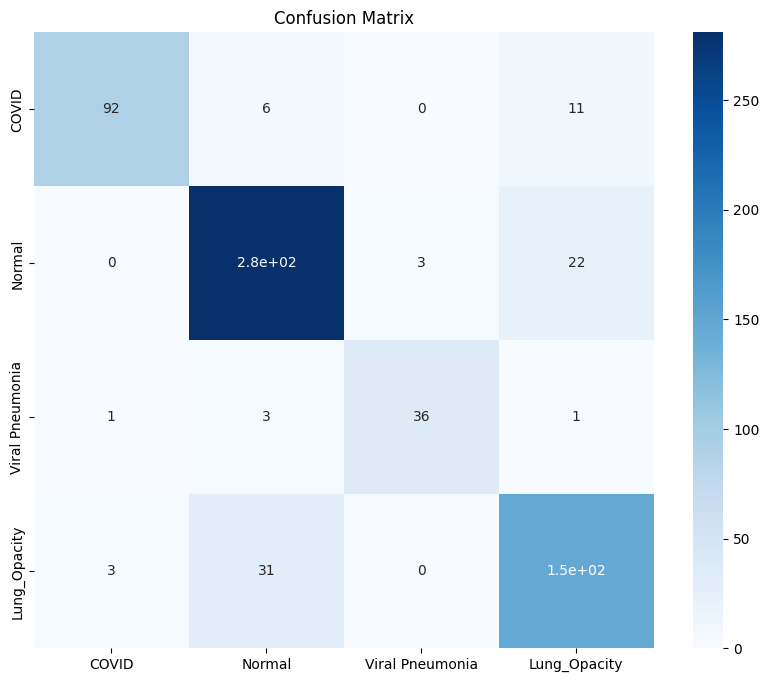

In [29]:
CM_plot(VGG_confusion_matrix, "Blues")

In [30]:
VGG_confusion_matrix_normalized=VGG_confusion_matrix.astype('float')/VGG_confusion_matrix.sum(axis=1)[:,np.newaxis]

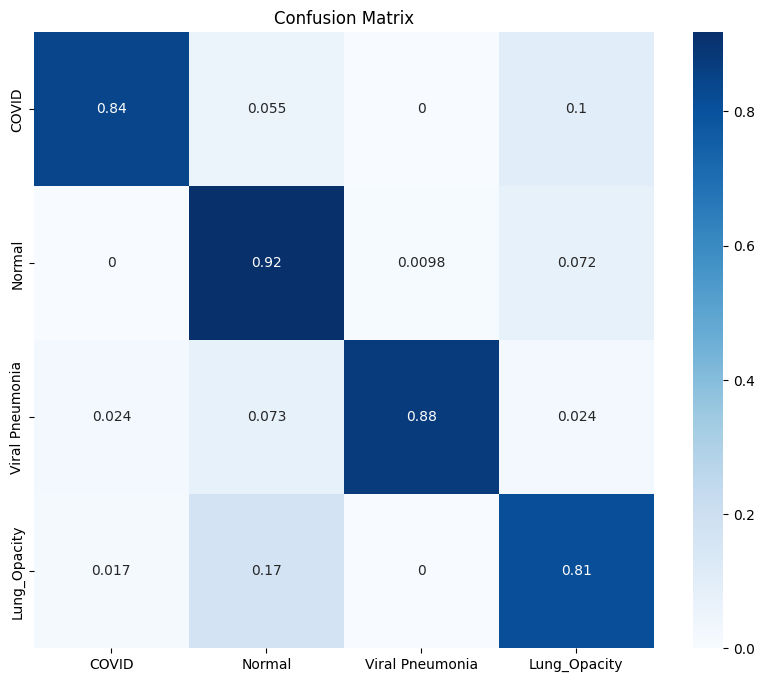

In [31]:
CM_plot(VGG_confusion_matrix_normalized, "Blues")